# Weather Prediction — Will it Rain Tomorrow?

This notebook is a compact, presentation-ready mini ML project. It predicts whether it will rain tomorrow (`RainTomorrow`) using multiple models. The notebook is concise and includes short explanations before each code block for viva.

**Models included:** Logistic Regression, Random Forest, KNN, SVM

**Note:** Per request, no feature scaling is applied to keep the notebook simple. KNN and SVM normally benefit from scaling — this point is mentioned where relevant.

## 1. Import libraries

Simple imports for data handling, visualization, and modeling.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Plot settings
sns.set(style='whitegrid')
plt.rcParams.update({'figure.max_open_warning': 0})  # avoid warning for many plots

## 2. Load dataset

Load `weather.csv` and show shape, columns, and target distribution.

In [ ]:
# Load dataset
df = pd.read_csv('/content/weather.csv')  # Update path if needed

# Basic info
print('Shape of dataset:', df.shape)
print('\nColumns:\n', df.columns.tolist())

# Show first rows
display(df.head())

# Target distribution
print('\nTarget distribution (RainTomorrow):')
print(df['RainTomorrow'].value_counts(dropna=False))

Shape of dataset: (366, 22)

Columns:
 ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow']


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,6.0,...,29,1019.7,1015.0,7,7,14.4,23.6,No,3.6,Yes
1,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,4.0,...,36,1012.4,1008.4,5,3,17.5,25.7,Yes,3.6,Yes
2,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,NNE,6.0,...,69,1009.5,1007.2,8,7,15.4,20.2,Yes,39.8,Yes
3,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,W,30.0,...,56,1005.5,1007.0,2,7,13.5,14.1,Yes,2.8,Yes
4,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,ESE,20.0,...,49,1018.3,1018.5,7,7,11.1,15.4,Yes,0.0,No



Target distribution (RainTomorrow):
RainTomorrow
No     300
Yes     66
Name: count, dtype: int64


## 3. Basic information & missing values

Show info and missing values per column.

In [ ]:
# Dataset info and missing values
print(df.info())
print('\nMissing values per column:')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        366 non-null    float64
 1   MaxTemp        366 non-null    float64
 2   Rainfall       366 non-null    float64
 3   Evaporation    366 non-null    float64
 4   Sunshine       363 non-null    float64
 5   WindGustDir    363 non-null    object 
 6   WindGustSpeed  364 non-null    float64
 7   WindDir9am     335 non-null    object 
 8   WindDir3pm     365 non-null    object 
 9   WindSpeed9am   359 non-null    float64
 10  WindSpeed3pm   366 non-null    int64  
 11  Humidity9am    366 non-null    int64  
 12  Humidity3pm    366 non-null    int64  
 13  Pressure9am    366 non-null    float64
 14  Pressure3pm    366 non-null    float64
 15  Cloud9am       366 non-null    int64  
 16  Cloud3pm       366 non-null    int64  
 17  Temp9am        366 non-null    float64
 18  Temp3pm   

## 4. Correlation heatmap (improved)

This helps identify strong relationships quickly.

## 4.1 Encode categorical variables for correlation heatmap

Temporarily encode categorical variables to numeric for correlation calculation.

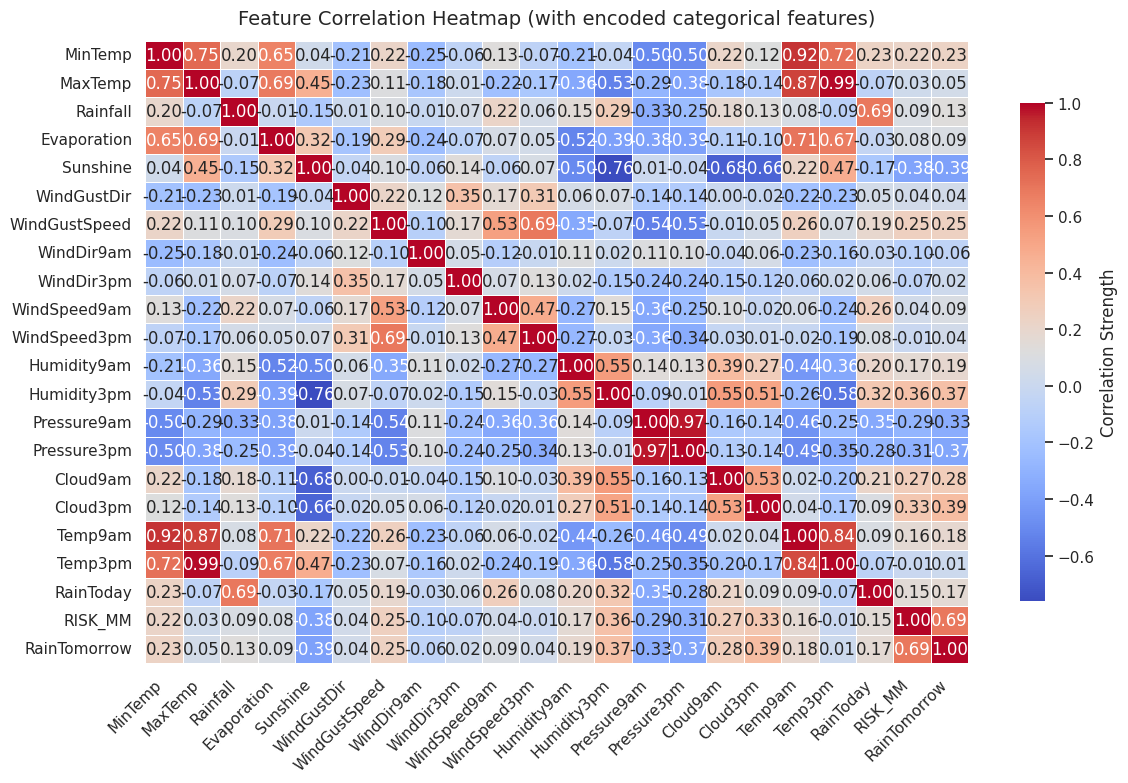

In [ ]:
# Create a copy of the DataFrame to avoid modifying the original
df_encoded = df.copy()

# Identify categorical columns
cat_cols_corr = df_encoded.select_dtypes(include='object').columns.tolist()

# Exclude the target variable if it's in the list
if 'RainTomorrow' in cat_cols_corr:
    cat_cols_corr.remove('RainTomorrow')
if 'RainToday' in cat_cols_corr:
    cat_cols_corr.remove('RainToday')

# Use LabelEncoder to convert categorical columns to numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in cat_cols_corr:
    if col in df_encoded.columns:
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str)) # Convert to string to handle potential NaNs

# Encode RainToday and RainTomorrow separately as they are binary
if 'RainToday' in df_encoded.columns:
    df_encoded['RainToday'] = df_encoded['RainToday'].map({'No': 0, 'Yes': 1})
if 'RainTomorrow' in df_encoded.columns:
    df_encoded['RainTomorrow'] = df_encoded['RainTomorrow'].map({'No': 0, 'Yes': 1})


# Now calculate correlation on the encoded DataFrame
corr = df_encoded.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5,
            cbar_kws={'shrink':0.8, 'label':'Correlation Strength'})
plt.title('Feature Correlation Heatmap (with encoded categorical features)', fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 5. Drop unnecessary columns

Drop columns that are redundant or may leak information (`RISK_MM` may leak tomorrow's rainfall).

In [ ]:
# Drop columns that are redundant or might leak target information
drop_cols = ['Evaporation', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RISK_MM']
cols_present = [c for c in drop_cols if c in df.columns]
print('Columns to drop (present in data):', cols_present)

data = df.drop(columns=cols_present)
print('\nNew shape:', data.shape)

Columns to drop (present in data): ['Evaporation', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RISK_MM']

New shape: (366, 16)


## 6. Handle missing values

Impute numeric columns with mean and categorical with mode.

In [ ]:
# Separate features and target
target = 'RainTomorrow'
X = data.drop(columns=[target])
y = data[target]

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

print('Numeric columns:', num_cols)
print('Categorical columns:', cat_cols)

# Impute numeric with mean
num_imputer = SimpleImputer(strategy='mean')
X[num_cols] = num_imputer.fit_transform(X[num_cols])

# Impute categorical with most frequent
cat_imputer = SimpleImputer(strategy='most_frequent')
if cat_cols:
    X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# Confirm no missing values remain in X
print('\nTotal missing values in features after imputation:', X.isnull().sum().sum())

Numeric columns: ['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm']
Categorical columns: ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

Total missing values in features after imputation: 0


## 7. Encode categorical variables

Convert text categories to numeric labels using LabelEncoder.

In [29]:
# Encode categorical features (Label Encoding)
le_dict = {} # Initialize an empty dictionary to store encoders
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col])
    le_dict[col] = le # Store the fitted encoder in the dictionary

# Show sample
display(X.head())

,MinTemp,MaxTemp,Rainfall,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainToday
0,8.0,24.3,0.0,6.3,7,30.0,12,7,6.0,20.0,68.0,29.0,1019.7,1015.0,0
1,14.0,26.9,3.6,9.7,1,39.0,0,13,4.0,17.0,80.0,36.0,1012.4,1008.4,1
2,13.7,23.4,3.6,3.3,7,85.0,3,5,6.0,6.0,82.0,69.0,1009.5,1007.2,1
3,13.3,15.5,39.8,9.1,7,54.0,14,13,30.0,24.0,62.0,56.0,1005.5,1007.0,1
4,7.6,16.1,2.8,10.6,10,50.0,10,2,20.0,28.0,68.0,49.0,1018.3,1018.5,1


## 8. Train-test split

Split with stratify to preserve class distribution.

In [31]:
# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

print('Training samples:', X_train.shape[0])
print('Testing samples:', X_test.shape[0])
print('\nTrain class distribution:\n', y_train.value_counts())
print('\nTest class distribution:\n', y_test.value_counts())

Training samples: 292
Testing samples: 74

Train class distribution:
 RainTomorrow
No     239
Yes     53
Name: count, dtype: int64

Test class distribution:
 RainTomorrow
No     61
Yes    13
Name: count, dtype: int64


## 9. Model 1 — Logistic Regression

Simple linear baseline.

In [32]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
print('Logistic Regression Accuracy:', round(acc_lr, 3))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.892

Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.93      0.93        61
         Yes       0.69      0.69      0.69        13

    accuracy                           0.89        74
   macro avg       0.81      0.81      0.81        74
weighted avg       0.89      0.89      0.89        74



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


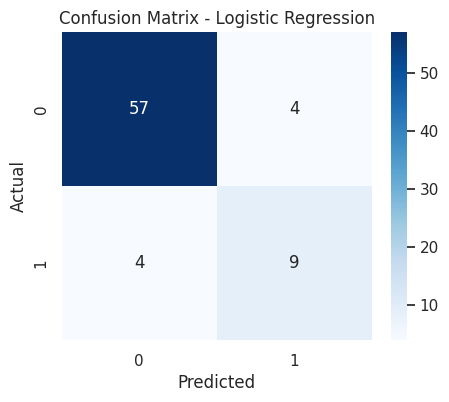

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 10. Model 2 — Random Forest

Ensemble model, handles non-linearity well.

In [34]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
print('Random Forest Accuracy:', round(acc_rf, 3))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.892

Classification Report:
              precision    recall  f1-score   support

          No       0.90      0.98      0.94        61
         Yes       0.86      0.46      0.60        13

    accuracy                           0.89        74
   macro avg       0.88      0.72      0.77        74
weighted avg       0.89      0.89      0.88        74



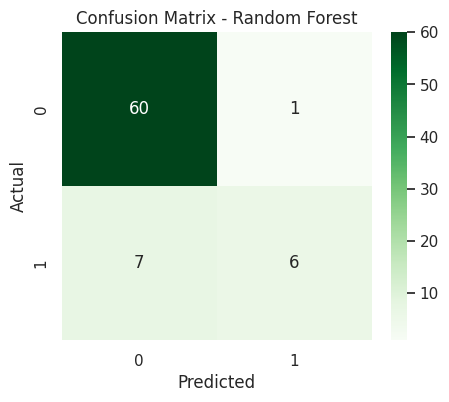

In [35]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 11. Model 3 — K-Nearest Neighbors (KNN)

KNN is simple but sensitive to feature scales (no scaling applied here per request).

In [36]:
# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
print('KNN Accuracy:', round(acc_knn, 3))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_knn))

KNN Accuracy: 0.878

Classification Report:
              precision    recall  f1-score   support

          No       0.87      1.00      0.93        61
         Yes       1.00      0.31      0.47        13

    accuracy                           0.88        74
   macro avg       0.94      0.65      0.70        74
weighted avg       0.89      0.88      0.85        74



## 12. Model 4 — Support Vector Machine (SVM)

SVM works well with clear margins; scaling typically helps. No scaling applied here per request.

In [37]:
# SVM
svm = SVC(kernel='rbf', probability=False, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

acc_svm = accuracy_score(y_test, y_pred_svm)
print('SVM Accuracy:', round(acc_svm, 3))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.824

Classification Report:
              precision    recall  f1-score   support

          No       0.82      1.00      0.90        61
         Yes       0.00      0.00      0.00        13

    accuracy                           0.82        74
   macro avg       0.41      0.50      0.45        74
weighted avg       0.68      0.82      0.74        74



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


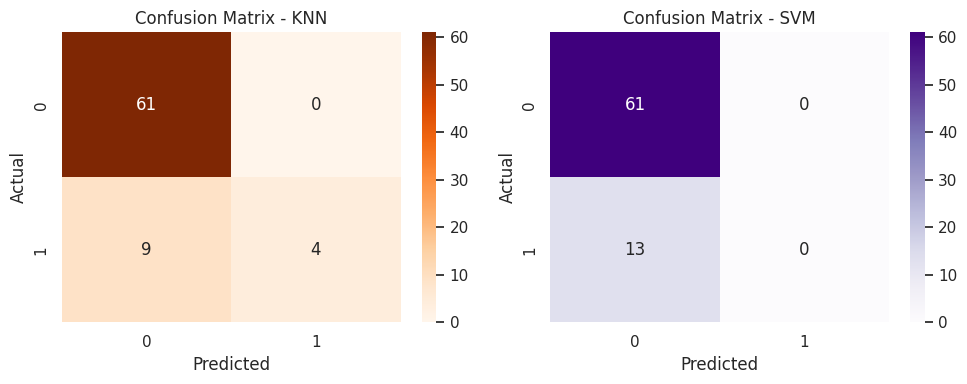

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_svm = confusion_matrix(y_test, y_pred_svm)

sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges', ax=axes[0])
axes[0].set_title('Confusion Matrix - KNN')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples', ax=axes[1])
axes[1].set_title('Confusion Matrix - SVM')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## 13. Model comparison

Compare accuracies of all models in a table and bar chart.

                 Model  Accuracy
0  Logistic Regression  0.891892
1        Random Forest  0.891892
2                  KNN  0.878378
3                  SVM  0.824324


/tmp/ipython-input-867539851.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results, palette='viridis')


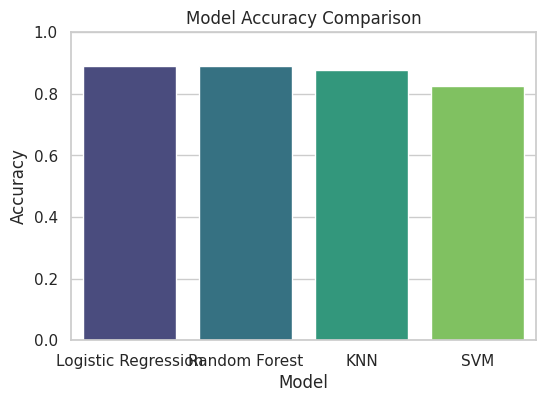

In [39]:
# Comparison table
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'KNN', 'SVM'],
    'Accuracy': [acc_lr, acc_rf, acc_knn, acc_svm]
}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print(results)

# Bar chart
plt.figure(figsize=(6,4))
sns.barplot(x='Model', y='Accuracy', data=results, palette='viridis')
plt.ylim(0,1)
plt.title('Model Accuracy Comparison')
plt.show()

## 14. Feature importance (Random Forest)

Show top features influencing prediction.

Sunshine         0.138715
Pressure3pm      0.124268
Humidity3pm      0.114991
Pressure9am      0.096934
MinTemp          0.094069
Humidity9am      0.079088
MaxTemp          0.066744
WindGustSpeed    0.057078
WindSpeed3pm     0.053339
WindSpeed9am     0.039844
dtype: float64


/tmp/ipython-input-2588709421.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(10), y=importances.head(10).index, palette='coolwarm')


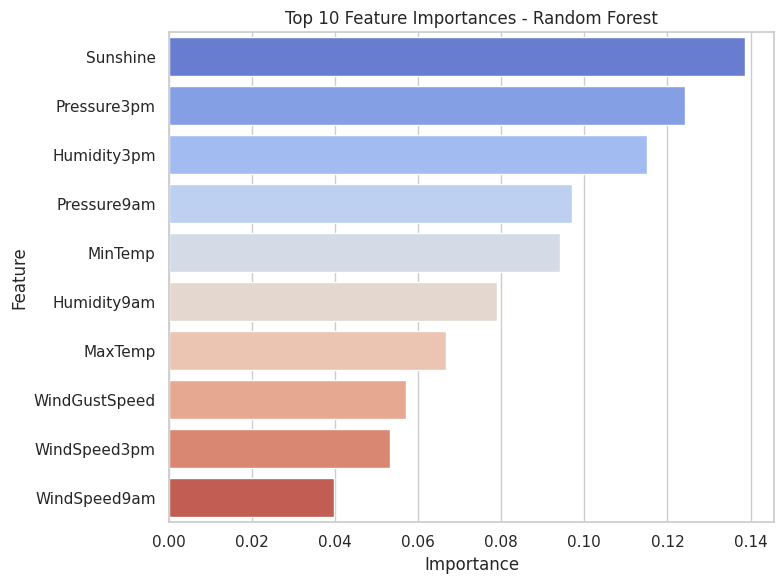

In [40]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances.head(10))

plt.figure(figsize=(8,6))
sns.barplot(x=importances.head(10), y=importances.head(10).index, palette='coolwarm')
plt.title('Top 10 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [41]:
# 1️⃣ Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train_scaled, y_train)
best_lr = lr_grid.best_estimator_

# 2️⃣ Random Forest
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_

# 3️⃣ KNN
knn = KNeighborsClassifier()
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train)
best_knn = knn_grid.best_estimator_

# 4️⃣ SVM
svm = SVC(probability=True, random_state=42)
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)
best_svm = svm_grid.best_estimator_

# Evaluate all tuned models
models = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'KNN': best_knn,
    'SVM': best_svm
}

results = {}
for name, model in models.items():
    acc = model.score(X_test_scaled, y_test)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

# Find best model
best_model_name = max(results, key=results.get)
print(f"\nBest Model: {best_model_name} with accuracy {results[best_model_name]:.4f}")

Logistic Regression Accuracy: 0.8649
Random Forest Accuracy: 0.8919
KNN Accuracy: 0.8649
SVM Accuracy: 0.9054

Best Model: SVM with accuracy 0.9054


## 8.1 Feature Scaling

Scale the features using `StandardScaler` for models that benefit from it (KNN, SVM).

In [42]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames to keep column names for clarity (optional but good practice)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print('X_train_scaled shape:', X_train_scaled.shape)
print('X_test_scaled shape:', X_test_scaled.shape)
display(X_train_scaled.head())

X_train_scaled shape: (292, 15)
X_test_scaled shape: (74, 15)


,MinTemp,MaxTemp,Rainfall,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainToday
0,0.546251,0.077428,-0.372741,0.268373,0.839062,-0.496638,0.202675,0.066980,0.696375,-0.091803,-0.560501,0.386032,-1.813942,-1.563361,-0.487122
1,1.681821,1.401997,-0.372741,0.353622,-1.463628,0.698777,0.462241,-1.266525,-0.080682,-0.091803,-0.405880,-0.386032,-0.460054,-0.631535,-0.487122
2,0.919124,0.412377,0.510450,-1.607119,-0.082014,-0.735720,-1.095157,-0.155271,-0.728230,-0.553982,1.913433,1.751993,-0.595443,-0.429640,2.052873
3,-1.301169,0.184003,-0.372741,0.552538,0.148255,0.698777,-0.576024,-0.155271,-0.080682,0.948101,-2.184019,-1.039318,-0.775961,-0.926613,-0.487122
4,-0.826603,-1.247141,-0.372741,0.524122,1.760139,0.379999,1.760073,-0.155271,1.343923,1.410280,-1.101673,-0.207864,0.668186,0.859386,-0.487122


In [46]:
import pickle

# Save the best SVM model
with open("svm_model.pkl", "wb") as file:
    pickle.dump(best_svm, file)

print("✅ SVM model saved successfully as svm_model.pkl")


✅ SVM model saved successfully as svm_model.pkl


In [47]:
# Save the scaler
with open("scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

# Save the feature columns
feature_columns = X_train.columns.tolist()
with open("feature_columns.pkl", "wb") as file:
    pickle.dump(feature_columns, file)

print("✅ Scaler and feature columns saved successfully.")


✅ Scaler and feature columns saved successfully.


## 15. Conclusion

Briefly state which model performed best and include a short note you can say in viva:

- Describe the best model and why it likely performed better.
- Mention that KNN and SVM usually benefit from scaling and can be improved by scaling or hyperparameter tuning.

**Suggested viva lines:**

"I tried four models. The Random Forest achieved the highest accuracy because it handles non-linear interactions and is robust to noisy features. Logistic Regression provided a simple baseline. KNN and SVM performed reasonably but could be improved by feature scaling and hyperparameter tuning."